In [1]:
# !pip install squarify
# !pip install pyproj

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import squarify
import re
import folium
import pyproj

In [3]:
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [4]:
class Chicken():

    def __init__(self):
        self.df = pd.read_csv("../../../서울특별시_일반음식점.csv", encoding="cp949")
        self.data = ""

    # 현재 필요 없는 컬럼 삭제
    def delete_columns(self):
        self.df.drop(columns=["Unnamed: 47",
                         "개방서비스아이디",
                         "개방자치단체코드",
                         "관리번호",
                         "인허가일자",
                         "인허가취소일자",
                         "상세영업상태코드",
                         "소재지전화",
                         "공장판매직종업원수",
                         "공장생산직종업원수",
                         "건물소유구분명",
                         "보증액",
                         "월세액",
                         "다중이용업소여부",
                         "시설총규모",
                         "전통업소지정번호",
                         "전통업소주된음식",
                         "홈페이지",
                         "남성종사자수",
                         "여성종사자수",
                         "영업장주변구분명",
                         "등급구분명",
                         "급수시설구분명",
                         "총종업원수",
                         "본사종업원수",
                         "공장사무직종업원수",
                         "소재지면적",
                         "최종수정시점",
                         "데이터갱신구분",
                         "데이터갱신일자",
                         "번호",
                         "도로명우편번호",
                         "소재지우편번호",
                         "개방서비스명"
                         ],inplace=True)
        # 폐업 후 재개업 하지 않은 음식점 삭제
        self.df.drop(index=(self.df[(self.df["폐업일자"].notna()) & (self.df["재개업일자"].isnull())].index),inplace=True)
        # 정상 영업하는 가게의 해당 컬럼들은 의미 없으므로 삭제
        self.df.drop(columns=["폐업일자",
                              "휴업시작일자",
                              "휴업종료일자",
                              "재개업일자",
                              "상세영업상태명",
                              "영업상태구분코드",
                              "영업상태명"
                              ],inplace=True)
        # 사업자명이 null값이 아니면서 치킨이 포함되는 음식점이거나 업태구분명, 위생업태명에 통닭이 포함되는 업체만 출력
        self.df = self.df[(self.df["사업장명"].notna()) & (self.df["사업장명"].str.contains("치킨")) | 
        (self.df["업태구분명"].str.contains("통닭")) | (self.df["위생업태명"].str.contains("통닭"))].reset_index(drop=True)
    
    # 도로명전체주소 컬럼에서 "구"를 추출
    @staticmethod
    def find_address_gu(address):
        words = address.split()  # 주소를 공백 기준으로 나누기
        for word in words:
            if word.endswith('구'):  # "구"로 끝나면 단어 전체 반환
                return word
    # 소재지전체주소 컬럼에서 "동"을 추출
    @staticmethod
    def find_address_dong(address):
        gu = re.search(r'([가-힣]+구)', address) # 주소에서 "구"를 찾기("동"은 대부분 "구" 바로 뒤에 나옴)
        if gu:
            words_after_gu = address[gu.end():]  # "구" 이후의 주소 부분을 가져오기
            dong = words_after_gu.split()[0] # 가져온 주소를 공백 기준으로 나눠서 첫번째 단어 선택
            if dong.endswith("동"): # 첫 번째 단어가 "동"으로 끝나는지 확인
                return dong
            elif dong.endswith("가"): # 첫 번째 단어가 "가"로 끝나는지 확인
                return dong
            elif dong.endswith("로"): # 첫 번째 단어가 "로"로 끝나는지 확인
                return dong
        return None  # 모든 조건을 만족하지 않으면 None(null)값 반환
    
    # 소재지전체주소 컬럼이 NaN인 컬럼들은 도로명전체주소 컬럼에서 "동"을 추출
    @staticmethod
    def find_address_dong2(address):
        words = address.split()
        for word in reversed(words):  # 뒤에서부터 확인
            if "동" in word:
                dong = re.sub(r'[^\w가-힣]', '', word)  # 한글과 숫자 외의 모든 문자를 제거
                return dong
        return None
    
    # "동" 컬럼을 전처리
    @staticmethod
    def process_dong(address):
        # 1. "ㅇㅇ1동"과 같은 주소에서 숫자만 제거하여 "ㅇㅇ동"으로 출력
        if "동" in address and re.search(r'\d+동$', address):
            return re.sub(r'\d+(?=동)', '', address)
        # 2. "동"으로 끝나는 주소는 그대로 동을 유지
        if address.endswith("동"):
            return address
        # 3. "동"을 포함하고 있고 뒤에 숫자+가가 있으면(ㅇㅇ동1가) "동"까지 추출
        if "동" in address and re.search(r'\d+가$', address):
            return re.sub(r'\d+가$', '', address)
        # 4. "ㅇㅇㅇ1가"와 같은 주소에서 숫자만 제거하여 "ㅇㅇㅇ가"로 출력
        if re.search(r'\d+가$', address):
            return re.sub(r'\d+', '', address)
        # 5. "동ㅇ동1가"와 같은 경우 "동ㅇ동"으로 출력
        if re.search(r'동.+\d+가$', address):
            address = re.sub(r'\d+가$', '', address)
        return address
    
    # "구" 값 초기화
    def insert_gu(self):
        self.df["구"] = None
        # 도로명전체주소에서 "구" 추출
        self.df.loc[self.df['도로명전체주소'].notna(), "구"] = self.df.loc[self.df['도로명전체주소'].notna(),
        "도로명전체주소"].apply(self.find_address_gu)
        # 소재지전체주소에서 "구" 추출 (도로명전체주소가 NaN인 경우만 업데이트)
        self.df.loc[self.df['소재지전체주소'].notna() & self.df["구"].isna(), "구"] = self.df.loc[self.df['소재지전체주소'].notna(),
        "소재지전체주소"].apply(self.find_address_gu)
    
    # "동" 컬럼 추가 및 전처리
    def insert_dong(self):
        for gu in self.df["구"].dropna().unique():
            self.df.loc[(self.df["구"] == gu) & (self.df["소재지전체주소"].notna()), "동"] = self.df.loc[(self.df["구"] == gu) &
            (self.df["소재지전체주소"].notna()), "소재지전체주소"].apply(self.find_address_dong)
        self.df.loc[self.df["동"].isna(), "동"] = self.df[self.df["동"].isna()]["도로명전체주소"].apply(self.find_address_dong2)
        self.df.loc[:,"동"] = self.df.loc[:,"동"].apply(self.process_dong)

    # 선택한 "구"로 트리맵 그래프 그리기
    def draw_graph(self):
        graph_data = self.df[self.df["구"] == self.data]["동"].value_counts().reset_index()
        plt.figure()
        squarify.plot(sizes=graph_data["count"], label=graph_data["동"])
        plt.show()

    # 선택한 "구"로 가게들 지도에 표시하기
    def draw_map(self):
        map_data = self.df[(self.df["구"] == self.data) & (self.df["좌표정보(x)"].notna()) & (self.df["좌표정보(y)"].notna())]
        # 좌표 변환 설정: EPSG:5181 (UTM-K) → EPSG:4326 (WGS84)
        proj_from = pyproj.CRS("EPSG:5181")
        proj_to = pyproj.CRS("EPSG:4326")
        transformer = pyproj.Transformer.from_crs(proj_from, proj_to, always_xy=True)

        # 지도 중심 좌표 (초기값: 첫 번째 데이터의 변환된 좌표 사용)
        center_x, center_y = map_data.iloc[0]["좌표정보(x)"], map_data.iloc[0]["좌표정보(y)"]
        center_lon, center_lat = transformer.transform(center_x, center_y)

        # Folium 지도 생성
        chicken_map = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles="OpenStreetMap")

        # 데이터프레임을 순회하며 마커 추가
        for _, row in map_data.iterrows():
            x, y = row["좌표정보(x)"], row["좌표정보(y)"]
            name = row["사업장명"]

            # 좌표 변환 (UTM-K → WGS84)
            lon, lat = transformer.transform(x, y)

            # 마커 추가
            folium.Marker(
                location=[lat, lon],
                popup=folium.Popup(name),
                icon=folium.Icon(color="red")
            ).add_to(chicken_map)

        # 지도 출력
        display(chicken_map)
    
    def start(self, data):
        self.data = data
        try:
            self.delete_columns()
            self.insert_gu()
            self.insert_dong()
        except:
            pass
        self.draw_graph()
        self.draw_map()

In [5]:
tmp = Chicken()

C:\Users\user\AppData\Local\Temp\ipykernel_2840\1365271802.py:4: DtypeWarning: Columns (22,27,39,41,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv("../../../서울특별시_일반음식점.csv", encoding="cp949")


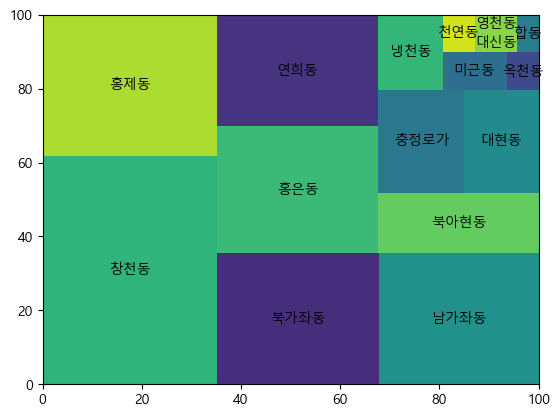

In [6]:
# "구"를 인자로 넣기
tmp.start("서대문구")